In [46]:
# I am using google colab for this project
!pip install catboost optuna category_encoders xgboost

## 1. Imports & Settings

In [60]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from category_encoders import CountEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool, cv
import optuna

np.random.seed(42)

In [8]:
df = pd.read_csv("TZ.csv")
df.head()

,ID,ID_клиента,фамилия,кредитный_рейтинг,город,пол,возраст,стаж_в_банке,баланс_депозита,число_продуктов,есть_кредитка,активный_клиент,оценочная_зарплата,ушел_из_банка
0,0,15709511.0,Тестов55,754.0,Астана,Male,40.0,8.0,102954.68,2.0,1.0,1.0,149238.35,0.0
1,1,15592761.0,Тестов539,579.0,Алматы,Female,28.0,1.0,NaN,2.0,1.0,0.0,64869.32,0.0
2,2,15579914.0,Тестов275,744.0,Алматы,Female,56.0,5.0,NaN,1.0,1.0,0.0,158816.03,1.0
3,3,15669611.0,Есенгельдиев,697.0,Алматы,Male,29.0,2.0,NaN,2.0,1.0,0.0,55775.72,0.0
4,4,15761775.0,Тестов451,628.0,Алматы,Female,22.0,9.0,NaN,2.0,1.0,0.0,49653.39,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  15000 non-null  int64  
 1   ID_клиента          15000 non-null  float64
 2   фамилия             15000 non-null  object 
 3   кредитный_рейтинг   15000 non-null  float64
 4   город               15000 non-null  object 
 5   пол                 15000 non-null  object 
 6   возраст             15000 non-null  float64
 7   стаж_в_банке        15000 non-null  float64
 8   баланс_депозита     5316 non-null   float64
 9   число_продуктов     15000 non-null  float64
 10  есть_кредитка       15000 non-null  float64
 11  активный_клиент     15000 non-null  float64
 12  оценочная_зарплата  15000 non-null  float64
 13  ушел_из_банка       15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [10]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,15000.0,NaN,NaN,NaN,7499.5,4330.271354,0.0,3749.75,7499.5,11249.25,14999.0
ID_клиента,15000.0,NaN,NaN,NaN,15796534.071133,12709374.505458,15565779.0,15634491.0,15690526.0,15757579.75,1572242404.0
фамилия,15000,836,Тестов677,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
кредитный_рейтинг,15000.0,NaN,NaN,NaN,658.851467,72.587026,431.0,602.0,662.0,709.0,850.0
город,15000,3,Алматы,8971,NaN,NaN,NaN,NaN,NaN,NaN,NaN
пол,15000,2,Male,8358,NaN,NaN,NaN,NaN,NaN,NaN,NaN
возраст,15000.0,NaN,NaN,NaN,37.888,8.257409,18.0,32.0,37.0,42.0,74.0
стаж_в_банке,15000.0,NaN,NaN,NaN,5.033333,2.808359,0.0,3.0,5.0,7.0,10.0
баланс_депозита,5316.0,NaN,NaN,NaN,121681.886227,22875.768239,753.37,106392.525,122570.69,137226.87,187530.66
число_продуктов,15000.0,NaN,NaN,NaN,1.590733,0.535587,1.0,1.0,2.0,2.0,4.0


In [11]:
# Target distribution

target_col = "ушел_из_банка"
df[target_col].value_counts(normalize=True)

,proportion
ушел_из_банка,
0.0,0.796133
1.0,0.203867


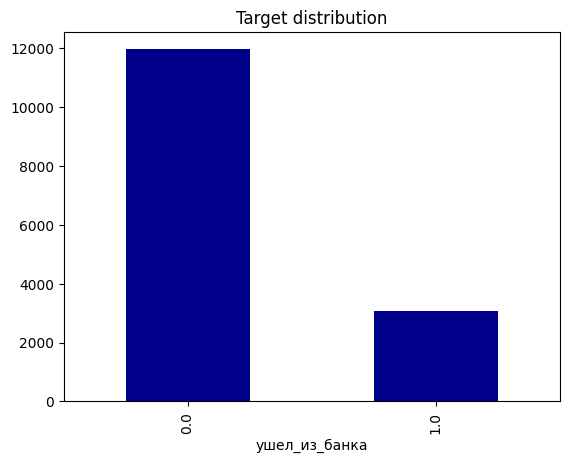

In [12]:
# Target distribution on a bar chart

df[target_col].value_counts().plot(kind="bar", title="Target distribution", color='darkblue')
plt.show()

## Implementing EDA


,0
баланс_депозита,0.6456
ID,0.0000
фамилия,0.0000
кредитный_рейтинг,0.0000
город,0.0000
ID_клиента,0.0000
пол,0.0000
возраст,0.0000
стаж_в_банке,0.0000
число_продуктов,0.0000


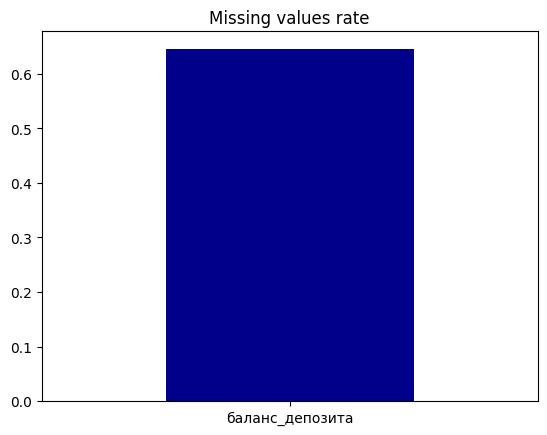

In [13]:
# Exploring missing values

missing_values = df.isna().mean().sort_values(ascending=False)
display(missing_values)

missing_values[missing_values > 0].plot(kind="bar", title="Missing values rate", color='darkblue', rot=0)
plt.show()

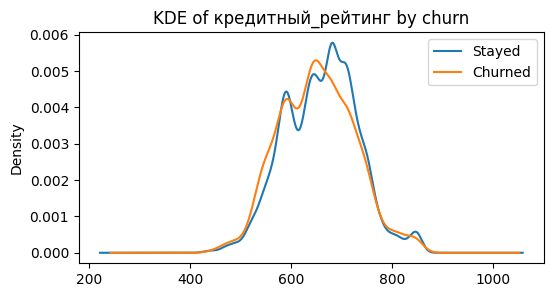

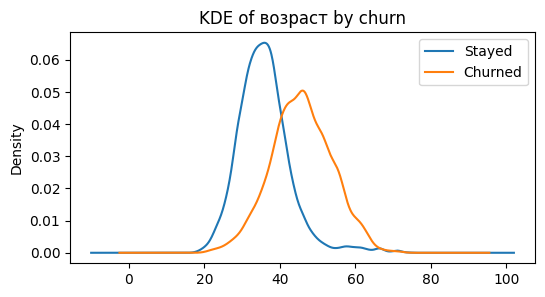

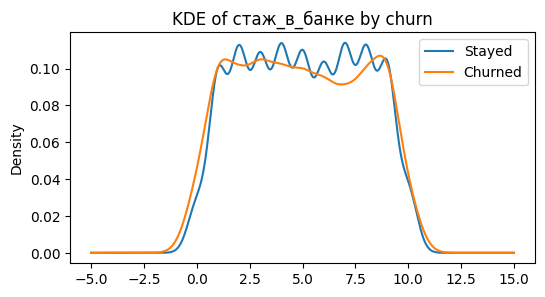

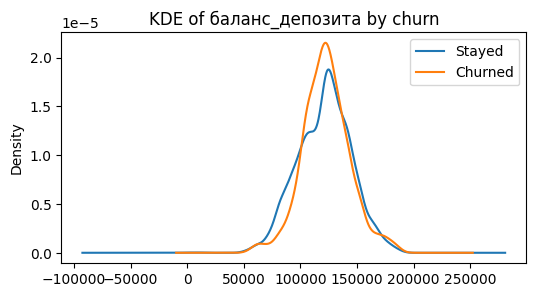

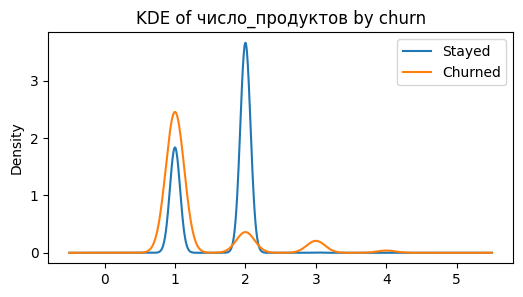

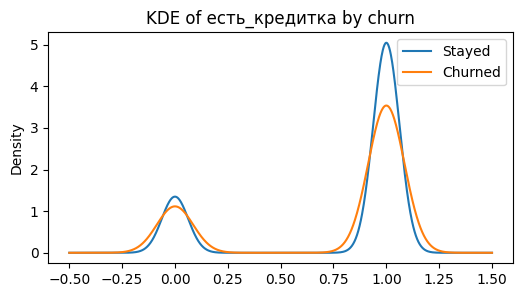

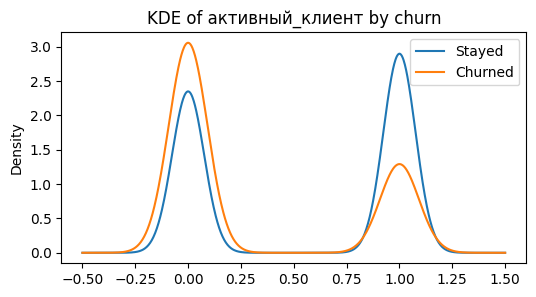

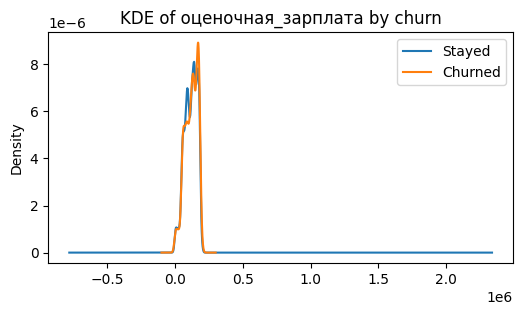

In [14]:
# Exploring numeri values by churn, using KDE

numeric_cols = [
    "кредитный_рейтинг", "возраст", "стаж_в_банке",
    "баланс_депозита", "число_продуктов",
    "есть_кредитка", "активный_клиент", "оценочная_зарплата"
]

for col in numeric_cols:
    plt.figure(figsize = (6,3))
    df[df[target_col] == 0][col].plot(kind = "kde", label = "Stayed")
    df[df[target_col] == 1][col].plot(kind = "kde", label = "Churned")
    plt.title(f"KDE of {col} by churn")
    plt.legend()
    plt.show()

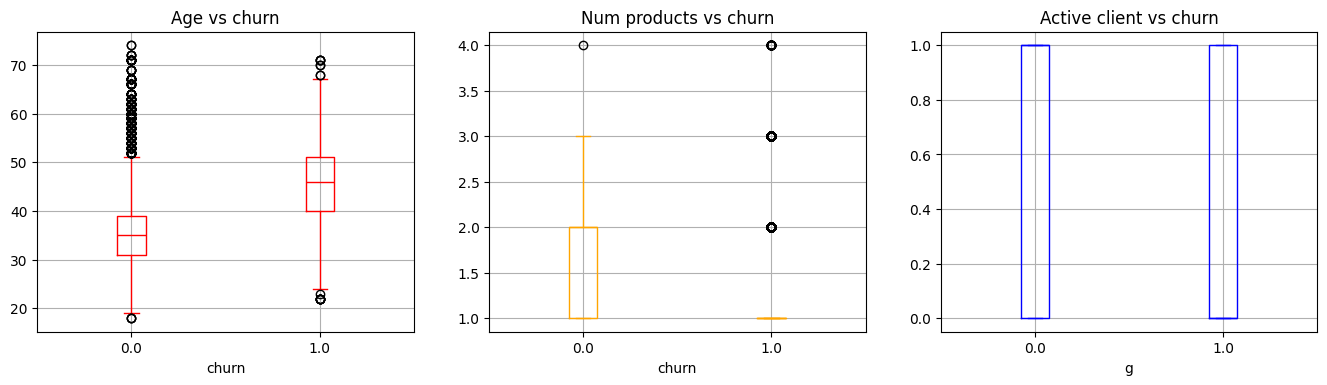

In [15]:
# Let's see possible factors to churn

fig, axes = plt.subplots(1, 3, figsize=(16,4))

df.boxplot(column="возраст", by=target_col, ax=axes[0], color='red')
axes[0].set_title("Age vs churn"); axes[0].set_xlabel("churn")

df.boxplot(column="число_продуктов", by=target_col, ax=axes[1], color = 'orange')
axes[1].set_title("Num products vs churn"); axes[1].set_xlabel("churn")

df.boxplot(column="активный_клиент", by=target_col, ax=axes[2], color = 'blue')
axes[2].set_title("Active client vs churn"); axes[2].set_xlabel("g")

plt.suptitle("")
plt.show()

,ушел_из_банка
город,
Атырау,0.419867
Астана,0.158988
Алматы,0.155278


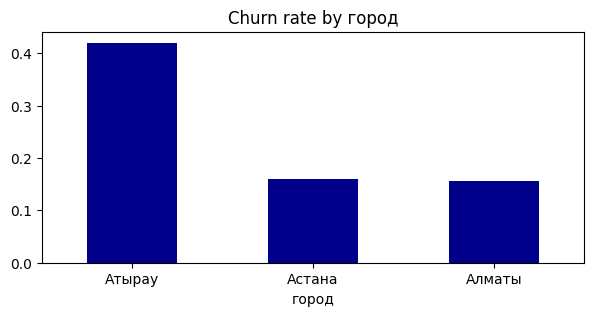

,ушел_из_банка
пол,
Female,0.283047
Male,0.140943


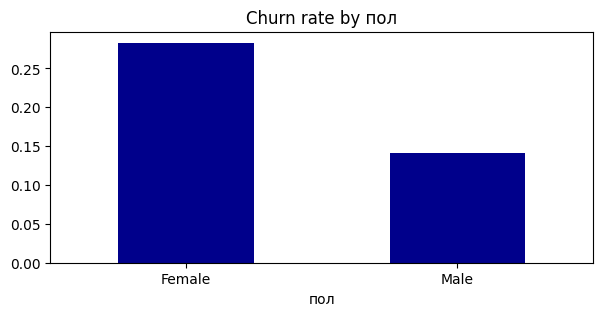

In [16]:
# Categorical churn rates like city, gender columns

for col in ["город", "пол"]:
    rate = df.groupby(col)[target_col].mean().sort_values(ascending=False)
    display(rate.head(10))
    rate.plot(kind="bar", title=f"Churn rate by {col}", figsize=(7,3), color ='darkblue', rot = 0)
    plt.show()

,ушел_из_банка
баланс_депозита_missing,
0,0.287998
1,0.157683


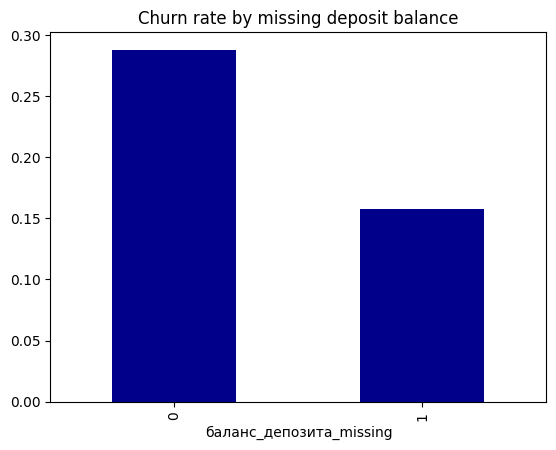

In [17]:
# Let's see the missing values distribution by churn

df["баланс_депозита_missing"] = df["баланс_депозита"].isna().astype(int)
missing_rate = df.groupby("баланс_депозита_missing")[target_col].mean()
display(missing_rate)

missing_rate.plot(kind="bar", title="Churn rate by missing deposit balance", color = 'darkblue')
plt.show()

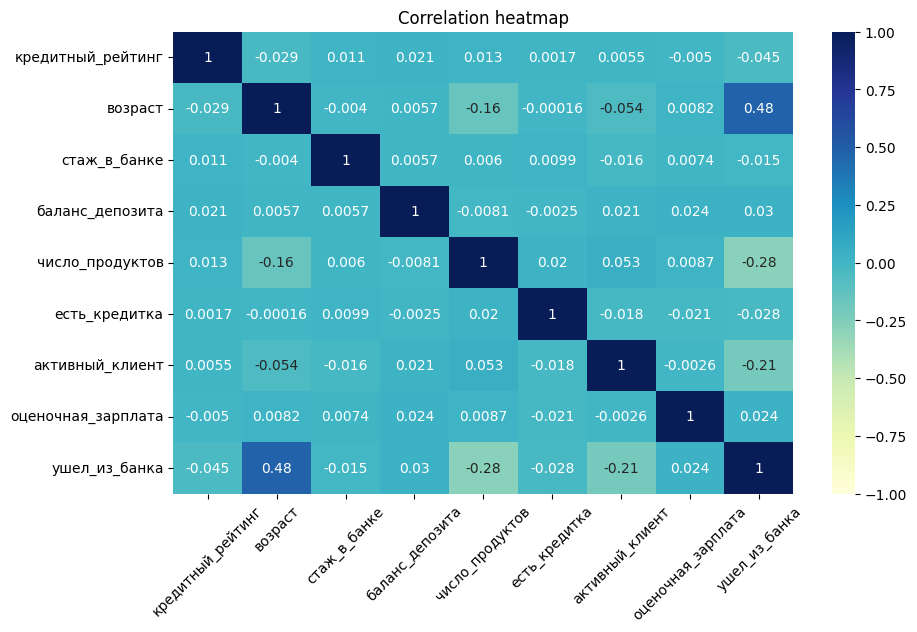

,ушел_из_банка
ушел_из_банка,1.000000
возраст,0.481368
баланс_депозита,0.030255
оценочная_зарплата,0.023511
стаж_в_банке,-0.015022
есть_кредитка,-0.028121
кредитный_рейтинг,-0.045404
активный_клиент,-0.205727
число_продуктов,-0.282240


In [20]:
# Now let's take a look at correlation heatmap on numeric values

corr = df[numeric_cols + [target_col]].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, vmin=-1, vmax=1, cmap='YlGnBu', annot=True)
plt.xticks(rotation=45)
plt.title("Correlation heatmap")
plt.show()

corr[target_col].sort_values(ascending=False)

,0
возраст,0.145821
число_продуктов,0.123121
город,0.027717
активный_клиент,0.024092
пол,0.017682
баланс_депозита_missing,0.014511
баланс_депозита,0.013874
оценочная_зарплата,0.003770
фамилия,0.000415
кредитный_рейтинг,0.000000


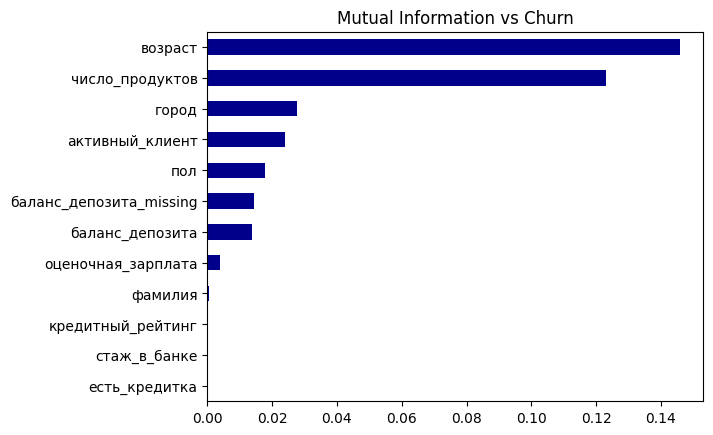

In [21]:
# Mutual information ranking - nonlinear importance
data_1 = df.copy()
for col in ["город", "пол", "фамилия"]:
    lab_encoder = LabelEncoder()
    data_1[col] = lab_encoder.fit_transform(data_1[col].astype(str))

data_1 = data_1.fillna(-10)
X_mi = data_1.drop(columns=["ID","ID_клиента", target_col])
y_mi = data_1[target_col].astype(int)

mi = mutual_info_classif(X_mi, y_mi, random_state=42)
mi_s = pd.Series(mi, index=X_mi.columns).sort_values(ascending=False)
display(mi_s)

mi_s.plot(kind="barh", color = "darkblue", title="Mutual Information vs Churn")
plt.gca().invert_yaxis()
plt.show()

## Preprocessing & Feature Engineering

In [22]:
df[['баланс_депозита','баланс_депозита_missing']]

,баланс_депозита,баланс_депозита_missing
0,102954.68,0
1,NaN,1
2,NaN,1
3,NaN,1
4,NaN,1
...,...,...
14995,NaN,1
14996,NaN,1
14997,NaN,1
14998,107764.75,0


In [23]:
drop_cols = ["ID", "ID_клиента"]
cat_low = ["город", "пол"]
cat_high = ["фамилия"]

num_cols = [
    "кредитный_рейтинг",
    "возраст",
    "стаж_в_банке",
    "баланс_депозита",
    "баланс_депозита_missing",
    "число_продуктов",
    "есть_кредитка",
    "активный_клиент",
    "оценочная_зарплата",
]

feature_cols = [c for c in df.columns if c not in drop_cols + [target_col]]

X = df[feature_cols]
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape

((12000, 12), (3000, 12))

In [25]:
# So we build a pipleline for our entire preprocessing

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_low_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

cat_high_pipe = Pipeline(steps=[
    ("count", CountEncoder(cols=cat_high)),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat_low", cat_low_pipe, cat_low),
        ("cat_high", cat_high_pipe, cat_high),
    ],
    remainder="drop",
)

## Modeling and Hyperparameter Tuning

In [26]:
logreg = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

logreg_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", logreg),
])

logreg_pipe.fit(X_train, y_train)
proba_lr = logreg_pipe.predict_proba(X_test)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

auc_lr = roc_auc_score(y_test, proba_lr)
prec_lr = precision_score(y_test, pred_lr)
rec_lr = recall_score(y_test, pred_lr)
f1_lr = f1_score(y_test, pred_lr)

auc_lr, prec_lr, rec_lr, f1_lr

(np.float64(0.8822557777996737),
 0.5330444203683641,
 0.803921568627451,
 0.641042345276873)

In [27]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88      2388
           1       0.53      0.80      0.64       612

    accuracy                           0.82      3000
   macro avg       0.74      0.81      0.76      3000
weighted avg       0.86      0.82      0.83      3000



In [35]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc_lr = cross_val_score(logreg_pipe, X_train, y_train, cv=stratified_kfold, scoring="roc_auc").mean()
cv_auc_lr

np.float64(0.8882819766149168)

In [45]:
# Random Forest model

rf_params = {
    "clf__n_estimators": [200, 400, 600],
    "clf__max_depth": [None, 6, 10],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__class_weight": ["balanced"]
}

rf_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

rf_grid = GridSearchCV(
    rf_pipe,
    param_grid=rf_params,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

proba_rf = rf_best.predict_proba(X_test)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

auc_rf = roc_auc_score(y_test, proba_rf)
prec_rf = precision_score(y_test, pred_rf)
rec_rf = recall_score(y_test, pred_rf)
f1_rf = f1_score(y_test, pred_rf)

print("Best RF params:", rf_grid.best_params_)
print("RandomForest metrics:", auc_rf, prec_rf, rec_rf, f1_rf)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best RF params: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}
RandomForest metrics: 0.9300403159588793 0.6813031161473088 0.7859477124183006 0.7298937784522003


In [48]:
#Tuning XGboost hyperparameters with optuna

def xgb_objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "random_state": 42,
        "n_jobs": -1
    }

    xgb_pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", XGBClassifier(**params))
    ])

    stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    auc = cross_val_score(
        xgb_pipe,
        X_train,
        y_train,
        cv=stratified,
        scoring="roc_auc"
    ).mean()

    return auc

xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=25)

print("Best XGB params:", xgb_study.best_params)

[I 2025-11-25 06:15:22,808] A new study created in memory with name: no-name-51d169e7-8394-43ec-973c-99c771c6335a
[I 2025-11-25 06:15:24,604] Trial 0 finished with value: 0.921967495010894 and parameters: {'n_estimators': 767, 'max_depth': 3, 'learning_rate': 0.1439816061438575, 'subsample': 0.7387949233564614, 'colsample_bytree': 0.9368182072087663, 'min_child_weight': 8, 'reg_lambda': 0.3720418195691074, 'reg_alpha': 0.048148603889831304}. Best is trial 0 with value: 0.921967495010894.
[I 2025-11-25 06:15:28,315] Trial 1 finished with value: 0.924372292027055 and parameters: {'n_estimators': 624, 'max_depth': 10, 'learning_rate': 0.045203877106410655, 'subsample': 0.7064064865747886, 'colsample_bytree': 0.8120016565136112, 'min_child_weight': 1, 'reg_lambda': 0.010834616817317514, 'reg_alpha': 2.6431197502402917}. Best is trial 1 with value: 0.924372292027055.
[I 2025-11-25 06:15:30,835] Trial 2 finished with value: 0.906292236952963 and parameters: {'n_estimators': 769, 'max_depth':

Best XGB params: {'n_estimators': 792, 'max_depth': 3, 'learning_rate': 0.02349813022526603, 'subsample': 0.9664653900960074, 'colsample_bytree': 0.6565538028010528, 'min_child_weight': 5, 'reg_lambda': 0.20414210332064378, 'reg_alpha': 0.9127722366367675}


In [49]:
# Training the best performing model

best_xgb = XGBClassifier(
    **xgb_study.best_params,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)

xgb_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", best_xgb)
])

xgb_pipe.fit(X_train, y_train)

proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]
pred_xgb = (proba_xgb >= 0.5).astype(int)

auc_xgb = roc_auc_score(y_test, proba_xgb)
prec_xgb = precision_score(y_test, pred_xgb)
rec_xgb = recall_score(y_test, pred_xgb)
f1_xgb = f1_score(y_test, pred_xgb)

print("XGBoost metrics:", auc_xgb, prec_xgb, rec_xgb, f1_xgb)


XGBoost metrics: 0.934046594628918 0.8035363457760314 0.6683006535947712 0.7297056199821588


## CatBoost + Optuna tuning

In [29]:
cat_cols = ["город", "пол", "фамилия"]

X_train_catboost = X_train.copy()
X_test_catboost = X_test.copy()
for c in cat_cols:
    X_train_catboost[c] = X_train_catboost[c].astype(str)
    X_test_catboost[c] = X_test_catboost[c].astype(str)

cat_indices = [X_train_catboost.columns.get_loc(c) for c in cat_cols]

In [38]:
def objective(trial):

    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "depth": trial.suggest_int("depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "iterations": trial.suggest_int("iterations", 300, 1200),
        "random_seed": 42,
        "auto_class_weights": "Balanced"
    }

    train_pool = Pool(
        X_train_catboost,
        y_train,
        cat_features=cat_indices
    )

    cv_results = cv(
        pool=train_pool,
        params=params,
        fold_count=3,
        shuffle=True,
        partition_random_seed=42,
        verbose=False
    )

    return cv_results["test-AUC-mean"].max()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

study.best_params, study.best_value

[I 2025-11-25 05:50:09,056] A new study created in memory with name: no-name-23040af6-2ecd-4841-9856-2cb1b2a32b51


Training on fold [0/3]

bestTest = 0.9304941207
bestIteration = 139

Training on fold [1/3]

bestTest = 0.9422777398
bestIteration = 211

Training on fold [2/3]


[I 2025-11-25 05:51:10,514] Trial 0 finished with value: 0.9341520791882054 and parameters: {'depth': 8, 'learning_rate': 0.029417926201643282, 'l2_leaf_reg': 1.4124311962511473, 'iterations': 753}. Best is trial 0 with value: 0.9341520791882054.



bestTest = 0.9299908284
bestIteration = 191

Training on fold [0/3]

bestTest = 0.9330609167
bestIteration = 158

Training on fold [1/3]

bestTest = 0.944619237
bestIteration = 418

Training on fold [2/3]


[I 2025-11-25 05:51:21,780] Trial 1 finished with value: 0.9362100738925103 and parameters: {'depth': 3, 'learning_rate': 0.06004610232582203, 'l2_leaf_reg': 0.0793233562650517, 'iterations': 506}. Best is trial 1 with value: 0.9362100738925103.



bestTest = 0.9322513642
bestIteration = 173

Training on fold [0/3]

bestTest = 0.9322082679
bestIteration = 396

Training on fold [1/3]

bestTest = 0.9429900511
bestIteration = 527

Training on fold [2/3]


[I 2025-11-25 05:51:51,308] Trial 2 finished with value: 0.935115907768609 and parameters: {'depth': 7, 'learning_rate': 0.015322609069936516, 'l2_leaf_reg': 3.888212562963536, 'iterations': 740}. Best is trial 1 with value: 0.9362100738925103.



bestTest = 0.9306478713
bestIteration = 582

Training on fold [0/3]

bestTest = 0.9326538308
bestIteration = 324

Training on fold [1/3]

bestTest = 0.9434477179
bestIteration = 626

Training on fold [2/3]


[I 2025-11-25 05:52:16,985] Trial 3 finished with value: 0.9356660003206354 and parameters: {'depth': 5, 'learning_rate': 0.021830480583017984, 'l2_leaf_reg': 0.0082950407055329, 'iterations': 841}. Best is trial 1 with value: 0.9362100738925103.



bestTest = 0.9315580972
bestIteration = 360

Training on fold [0/3]

bestTest = 0.9234037846
bestIteration = 11

Training on fold [1/3]

bestTest = 0.9387005808
bestIteration = 16

Training on fold [2/3]


[I 2025-11-25 05:53:03,177] Trial 4 finished with value: 0.9292874682304625 and parameters: {'depth': 8, 'learning_rate': 0.13113525459925615, 'l2_leaf_reg': 0.030282509444703724, 'iterations': 946}. Best is trial 1 with value: 0.9362100738925103.



bestTest = 0.9269435752
bestIteration = 9

Training on fold [0/3]

bestTest = 0.9325391695
bestIteration = 110

Training on fold [1/3]

bestTest = 0.9428987489
bestIteration = 163

Training on fold [2/3]


[I 2025-11-25 05:53:26,134] Trial 5 finished with value: 0.9352056015660565 and parameters: {'depth': 6, 'learning_rate': 0.10895354203738918, 'l2_leaf_reg': 9.141622462649195, 'iterations': 641}. Best is trial 1 with value: 0.9362100738925103.



bestTest = 0.9308486451
bestIteration = 80

Training on fold [0/3]

bestTest = 0.9324891495
bestIteration = 51

Training on fold [1/3]

bestTest = 0.9427277017
bestIteration = 84

Training on fold [2/3]


[I 2025-11-25 05:53:36,309] Trial 6 finished with value: 0.9346321973549796 and parameters: {'depth': 4, 'learning_rate': 0.15538351237012976, 'l2_leaf_reg': 0.0011131637170107987, 'iterations': 375}. Best is trial 1 with value: 0.9362100738925103.



bestTest = 0.9300008478
bestIteration = 42

Training on fold [0/3]

bestTest = 0.9330693816
bestIteration = 708

Training on fold [1/3]

bestTest = 0.9434897092
bestIteration = 709

Training on fold [2/3]


[I 2025-11-25 05:53:55,737] Trial 7 finished with value: 0.936046386157936 and parameters: {'depth': 4, 'learning_rate': 0.013133826438145327, 'l2_leaf_reg': 0.06440242512278353, 'iterations': 710}. Best is trial 1 with value: 0.9362100738925103.



bestTest = 0.9316367112
bestIteration = 698

Training on fold [0/3]

bestTest = 0.9328554499
bestIteration = 227

Training on fold [1/3]

bestTest = 0.9430574684
bestIteration = 345

Training on fold [2/3]


[I 2025-11-25 05:54:32,175] Trial 8 finished with value: 0.9355382862607092 and parameters: {'depth': 5, 'learning_rate': 0.040506776828055195, 'l2_leaf_reg': 0.10017021287161754, 'iterations': 1119}. Best is trial 1 with value: 0.9362100738925103.



bestTest = 0.9316910473
bestIteration = 261

Training on fold [0/3]

bestTest = 0.9332713855
bestIteration = 718

Training on fold [1/3]

bestTest = 0.9435035779
bestIteration = 719

Training on fold [2/3]


[I 2025-11-25 05:54:52,165] Trial 9 finished with value: 0.9361126934784338 and parameters: {'depth': 4, 'learning_rate': 0.011904143027389196, 'l2_leaf_reg': 9.392774010206749, 'iterations': 720}. Best is trial 1 with value: 0.9362100738925103.



bestTest = 0.9315696581
bestIteration = 719

Training on fold [0/3]

bestTest = 0.9328442916
bestIteration = 168

Training on fold [1/3]

bestTest = 0.9444589766
bestIteration = 290

Training on fold [2/3]


[I 2025-11-25 05:55:01,534] Trial 10 finished with value: 0.9362315642683313 and parameters: {'depth': 3, 'learning_rate': 0.06882672405842663, 'l2_leaf_reg': 0.33700024428136666, 'iterations': 414}. Best is trial 10 with value: 0.9362315642683313.



bestTest = 0.9321954866
bestIteration = 213

Training on fold [0/3]

bestTest = 0.9337454212
bestIteration = 154

Training on fold [1/3]

bestTest = 0.9448657915
bestIteration = 341

Training on fold [2/3]


[I 2025-11-25 05:55:09,991] Trial 11 finished with value: 0.93661462550623 and parameters: {'depth': 3, 'learning_rate': 0.06775547178304851, 'l2_leaf_reg': 0.6346928776037627, 'iterations': 351}. Best is trial 11 with value: 0.93661462550623.



bestTest = 0.9324039677
bestIteration = 157

Training on fold [0/3]

bestTest = 0.9329443316
bestIteration = 167

Training on fold [1/3]

bestTest = 0.9448118577
bestIteration = 267

Training on fold [2/3]


[I 2025-11-25 05:55:18,139] Trial 12 finished with value: 0.9363475688842463 and parameters: {'depth': 3, 'learning_rate': 0.07037119033100774, 'l2_leaf_reg': 0.5292786472091229, 'iterations': 363}. Best is trial 11 with value: 0.93661462550623.



bestTest = 0.9318883528
bestIteration = 221

Training on fold [0/3]

bestTest = 0.9327627205
bestIteration = 115

Training on fold [1/3]

bestTest = 0.9448118577
bestIteration = 286

Training on fold [2/3]


[I 2025-11-25 05:55:24,999] Trial 13 finished with value: 0.9363092077040992 and parameters: {'depth': 3, 'learning_rate': 0.08185858000086749, 'l2_leaf_reg': 0.6907620989573392, 'iterations': 306}. Best is trial 11 with value: 0.93661462550623.



bestTest = 0.9321053118
bestIteration = 147

Training on fold [0/3]

bestTest = 0.9331574938
bestIteration = 230

Training on fold [1/3]

bestTest = 0.9449081681
bestIteration = 368

Training on fold [2/3]


[I 2025-11-25 05:55:36,721] Trial 14 finished with value: 0.9365887995197668 and parameters: {'depth': 3, 'learning_rate': 0.04451643795344795, 'l2_leaf_reg': 0.28183447877847756, 'iterations': 521}. Best is trial 11 with value: 0.93661462550623.



bestTest = 0.9322941394
bestIteration = 285

Training on fold [0/3]

bestTest = 0.9332432973
bestIteration = 271

Training on fold [1/3]

bestTest = 0.9445757048
bestIteration = 387

Training on fold [2/3]


[I 2025-11-25 05:55:50,541] Trial 15 finished with value: 0.9363346270935177 and parameters: {'depth': 4, 'learning_rate': 0.040173545797610115, 'l2_leaf_reg': 0.25717712780365326, 'iterations': 531}. Best is trial 11 with value: 0.93661462550623.



bestTest = 0.9319299719
bestIteration = 257

Training on fold [0/3]

bestTest = 0.9308069382
bestIteration = 37

Training on fold [1/3]

bestTest = 0.9418566709
bestIteration = 51

Training on fold [2/3]


[I 2025-11-25 05:56:10,422] Trial 16 finished with value: 0.9335683353424024 and parameters: {'depth': 6, 'learning_rate': 0.1970413497070895, 'l2_leaf_reg': 1.9991609833496051, 'iterations': 537}. Best is trial 11 with value: 0.93661462550623.



bestTest = 0.9289391744
bestIteration = 29

Training on fold [0/3]

bestTest = 0.9319974144
bestIteration = 308

Training on fold [1/3]

bestTest = 0.9429264863
bestIteration = 464

Training on fold [2/3]


[I 2025-11-25 05:56:24,628] Trial 17 finished with value: 0.9353262896242752 and parameters: {'depth': 5, 'learning_rate': 0.027569176464768672, 'l2_leaf_reg': 0.01839775993996465, 'iterations': 474}. Best is trial 11 with value: 0.93661462550623.



bestTest = 0.9316952862
bestIteration = 290

Training on fold [0/3]

bestTest = 0.9330505279
bestIteration = 215

Training on fold [1/3]

bestTest = 0.9448303493
bestIteration = 438

Training on fold [2/3]


[I 2025-11-25 05:56:37,224] Trial 18 finished with value: 0.9363293058406864 and parameters: {'depth': 3, 'learning_rate': 0.04691024268431732, 'l2_leaf_reg': 0.14555367783471457, 'iterations': 574}. Best is trial 11 with value: 0.93661462550623.



bestTest = 0.9320043469
bestIteration = 272

Training on fold [0/3]

bestTest = 0.933117093
bestIteration = 120

Training on fold [1/3]

bestTest = 0.9441839142
bestIteration = 151

Training on fold [2/3]


[I 2025-11-25 05:56:49,746] Trial 19 finished with value: 0.9361899239480275 and parameters: {'depth': 4, 'learning_rate': 0.09927367855848433, 'l2_leaf_reg': 0.8408282199552896, 'iterations': 451}. Best is trial 11 with value: 0.93661462550623.



bestTest = 0.9315361316
bestIteration = 114



({'depth': 3,
  'learning_rate': 0.06775547178304851,
  'l2_leaf_reg': 0.6346928776037627,
  'iterations': 351},
 0.93661462550623)

In [39]:
best_params = study.best_params
best_params.update({
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": 42,
    "verbose": 100,
    "auto_class_weights": "Balanced",
})

cat_model = CatBoostClassifier(**best_params)
cat_model.fit(X_train_catboost, y_train, cat_features=cat_indices)

proba_cb = cat_model.predict_proba(X_test_catboost)[:, 1]
pred_cb = (proba_cb >= 0.5).astype(int)

auc_cb = roc_auc_score(y_test, proba_cb)
prec_cb = precision_score(y_test, pred_cb)
rec_cb = recall_score(y_test, pred_cb)
f1_cb = f1_score(y_test, pred_cb)

auc_cb, prec_cb, rec_cb, f1_cb

0:	total: 21.8ms	remaining: 7.63s
100:	total: 1.52s	remaining: 3.78s
200:	total: 2.42s	remaining: 1.8s
300:	total: 3.33s	remaining: 553ms
350:	total: 3.78s	remaining: 0us


(np.float64(0.9345714137134474),
 0.6224611708482676,
 0.8513071895424836,
 0.7191166321601105)

In [40]:
print(classification_report(y_test, pred_cb))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      2388
           1       0.62      0.85      0.72       612

    accuracy                           0.86      3000
   macro avg       0.79      0.86      0.81      3000
weighted avg       0.89      0.86      0.87      3000



## Model Comparison

In [51]:
results = pd.DataFrame([
    {"model": "LogisticRegression", "AUC": auc_lr, "precision": prec_lr, "recall": rec_lr, "F1": f1_lr},
    {"model": "RandomForest", "AUC": auc_rf, "precision": prec_rf, "recall": rec_rf, "F1": f1_rf},
    {"model": "XGBoost", "AUC": auc_xgb, "precision": prec_xgb, "recall": rec_xgb, "F1": f1_xgb},
    {"model": "CatBoost", "AUC": auc_cb, "precision": prec_cb, "recall": rec_cb, "F1": f1_cb},
])

results.sort_values("AUC", ascending=False)

,model,AUC,precision,recall,F1
3,CatBoost,0.934571,0.622461,0.851307,0.719117
2,XGBoost,0.934047,0.803536,0.668301,0.729706
1,RandomForest,0.930040,0.681303,0.785948,0.729894
0,LogisticRegression,0.882256,0.533044,0.803922,0.641042


## Validation Plots - best model

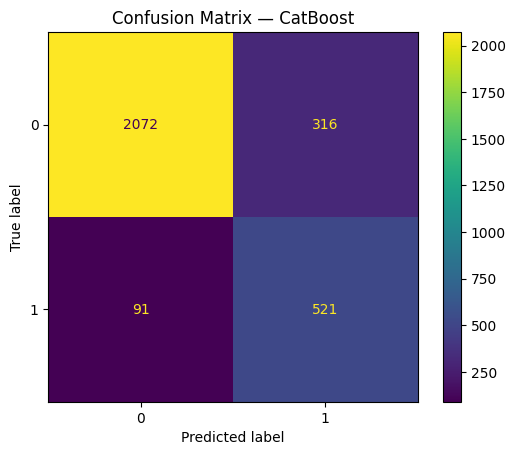

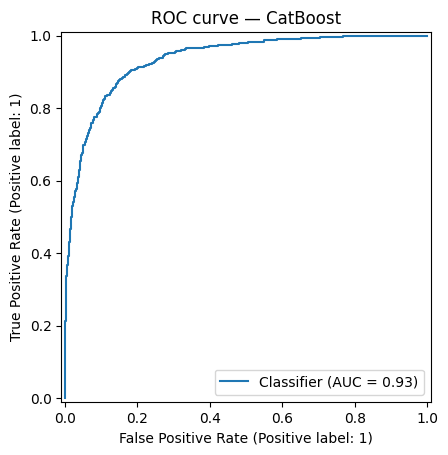

Best AUC: 0.9345714137134474


In [62]:
con_mat = confusion_matrix(y_test, pred_cb)
ConfusionMatrixDisplay(con_mat).plot()
plt.title(f"Confusion Matrix — CatBoost")
plt.show()

RocCurveDisplay.from_predictions(y_test, proba_cb)
plt.title(f"ROC curve — CatBoost")
plt.show()

print("Best AUC:", roc_auc_score(y_test, proba_cb))

## Feature Importance

,0
число_продуктов,35.810800
возраст,33.358699
активный_клиент,6.414827
город,5.648855
баланс_депозита,4.549209
пол,3.467571
кредитный_рейтинг,3.163515
баланс_депозита_missing,2.235763
оценочная_зарплата,2.170429
фамилия,1.566810


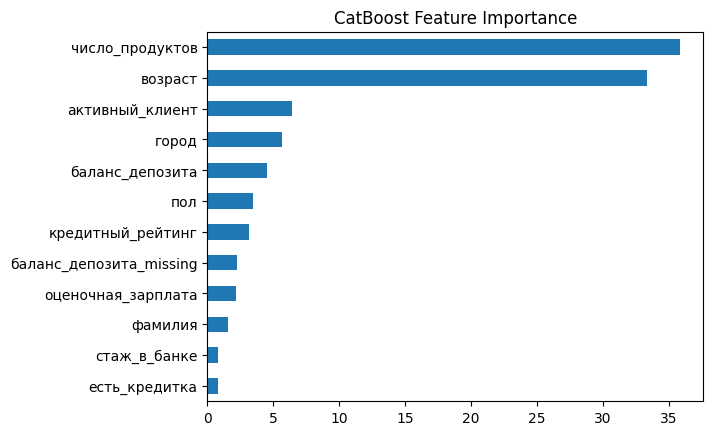

In [58]:
importances = cat_model.get_feature_importance()
fi = pd.Series(importances, index=X_train_catboost.columns).sort_values(ascending=False)
display(fi.head(15))
fi.head(15).plot(kind="barh", title="CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## Saving Best Model for API

In [59]:
from joblib import dump

final_bundle = {
    "model": cat_model,
    "meta": {
        "model_type": "catboost",
        "feature_cols": list(X_train_catboost.columns),
        "cat_cols": cat_cols
        }
    }

dump(final_bundle, "model.joblib")
print("Saved model to model.joblib")

Saved model to model.joblib


## The End of the notebook